**UNGGAH DATASET DARI GDRIVE**

In [2]:
!gdown 1bqPRaQJXC14s4G6F-mx6_f6IQcnDuJKL

Downloading...
From (original): https://drive.google.com/uc?id=1bqPRaQJXC14s4G6F-mx6_f6IQcnDuJKL
From (redirected): https://drive.google.com/uc?id=1bqPRaQJXC14s4G6F-mx6_f6IQcnDuJKL&confirm=t&uuid=46eb35d1-6365-4239-8404-d8b97440c9b3
To: /content/RegresiUTSTelkom.csv
100% 443M/443M [00:06<00:00, 70.2MB/s]


**LIBRARY**

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, callbacks, optimizers, regularizers

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F


**DATA LOADING & CLEANING**

In [4]:
df = pd.read_csv("/content/RegresiUTSTelkom.csv")

target_column = df.select_dtypes(include='int').columns[0]
y = df[target_column]
X = df.drop(columns=[target_column])

X.dropna(axis=1, how='all', inplace=True)
X.fillna(method='ffill', inplace=True)


<ipython-input-4-3319395033>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method='ffill', inplace=True)


**KORELASI & FEATURE SELECTION**

Fitur terpilih berdasarkan korelasi: ['49.94357', '73.0775', '-13.09905', '-25.01202', '-0.36994', '73.04667', '-18.60478', '-10.7366', '4.69525']


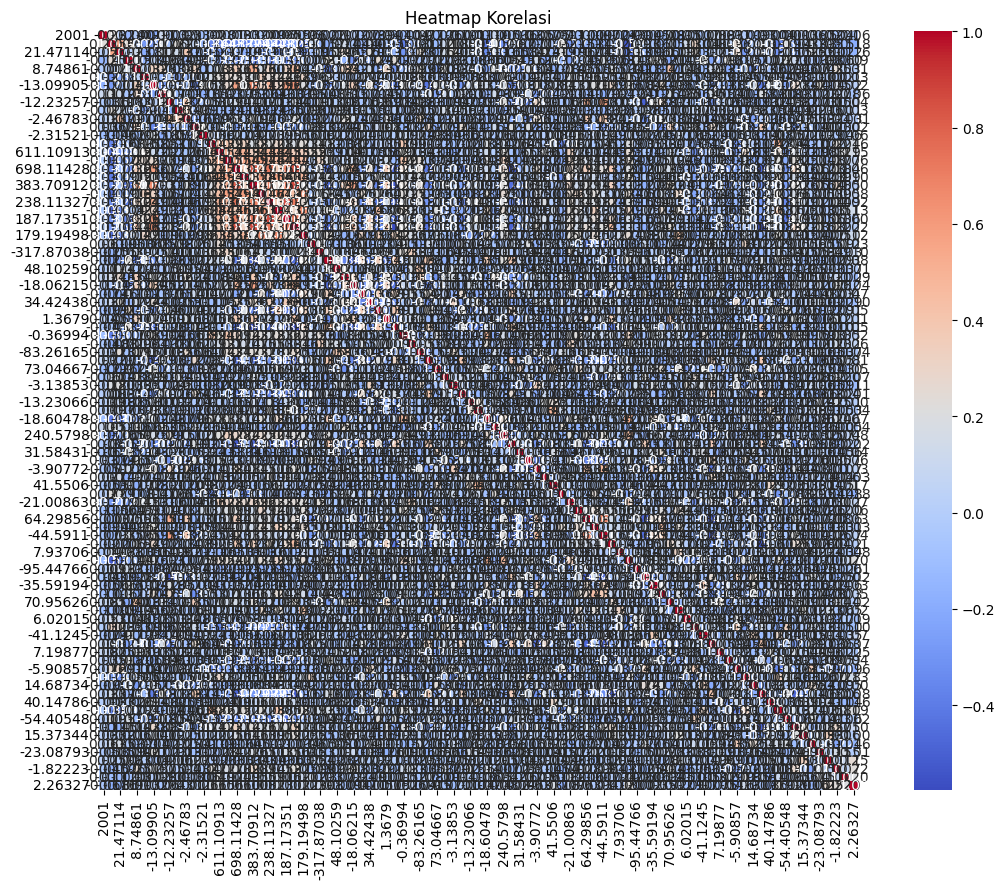

In [5]:
numerik_df = df.select_dtypes(include=['int64', 'float64'])
korelasi_target = numerik_df.corr()[target_column].abs().drop(target_column)

fitur_terpilih = korelasi_target[korelasi_target > 0.1].index.tolist()
print("Fitur terpilih berdasarkan korelasi:", fitur_terpilih)

plt.figure(figsize=(12, 9))
sns.heatmap(numerik_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Heatmap Korelasi")
plt.tight_layout()
plt.show()


**PREPROCESSING**

In [6]:
fitur_numerik = [col for col in fitur_terpilih if X[col].dtype in ['float64', 'int64']]
fitur_kategorikal = X.select_dtypes(include=['object', 'category']).columns.tolist()

pipeline_num = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

pipeline_cat = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', pipeline_num, fitur_numerik),
    ('cat', pipeline_cat, fitur_kategorikal)
])

X_transformed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)


**MODEL REGRESI: TENSORFLOW**

In [7]:
model_tf = tf.keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1)
])

model_tf.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

early_cb = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_tf = model_tf.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_cb],
    verbose=1
)


Epoch 1/100
12884/12884 ━━━━━━━━━━━━━━━━━━━━ 50s 4ms/step - loss: 1776100.3750 - mae: 1076.7474 - val_loss: 96.7155 - val_mae: 7.1738
Epoch 2/100
12884/12884 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step - loss: 100.0593 - mae: 7.2802 - val_loss: 96.9081 - val_mae: 6.9619
Epoch 3/100
12884/12884 ━━━━━━━━━━━━━━━━━━━━ 77s 3ms/step - loss: 98.8465 - mae: 7.2455 - val_loss: 95.5513 - val_mae: 7.0021
Epoch 4/100
12884/12884 ━━━━━━━━━━━━━━━━━━━━ 85s 4ms/step - loss: 99.1922 - mae: 7.2503 - val_loss: 95.4656 - val_mae: 7.1123
Epoch 5/100
12884/12884 ━━━━━━━━━━━━━━━━━━━━ 78s 3ms/step - loss: 98.6645 - mae: 7.2126 - val_loss: 95.7280 - val_mae: 7.0325
Epoch 6/100
12884/12884 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - loss: 99.1707 - mae: 7.2334 - val_loss: 95.3310 - val_mae: 7.0920
Epoch 7/100
12884/12884 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 98.5255 - mae: 7.2165 - val_loss: 96.6507 - val_mae: 7.4430
Epoch 8/100
12884/12884 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - loss: 97.6589 - mae: 7.1827 - val_loss: 95.2889 -

**EVALUASI TENSORFLOW**

3221/3221 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
[TensorFlow] MSE: 93.9670 | RMSE: 9.6937 | R²: 0.2083


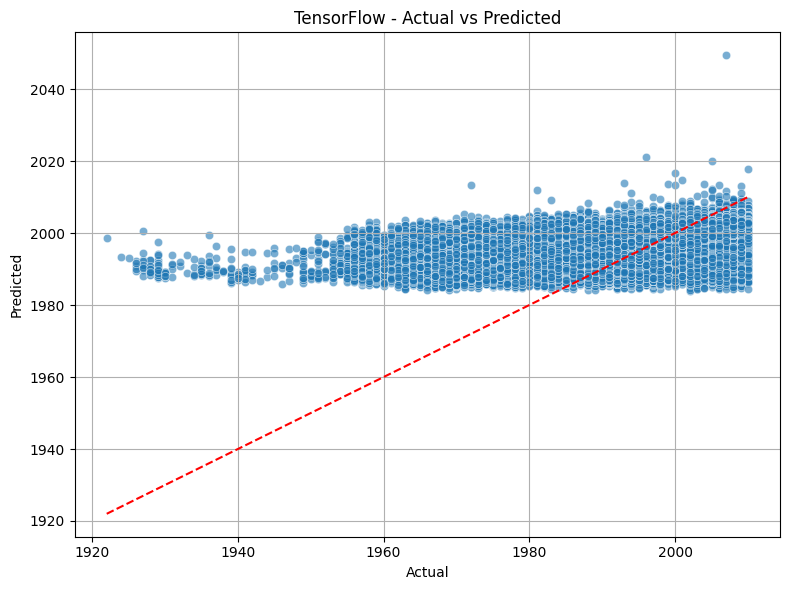

In [8]:
y_pred_tf = model_tf.predict(X_test).flatten()

mse_tf = mean_squared_error(y_test, y_pred_tf)
rmse_tf = np.sqrt(mse_tf)
r2_tf = r2_score(y_test, y_pred_tf)

print(f"[TensorFlow] MSE: {mse_tf:.4f} | RMSE: {rmse_tf:.4f} | R²: {r2_tf:.4f}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_tf, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('TensorFlow - Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()


**MODEL REGRESI: PYTORCH**

In [9]:
X_train_torch = torch.tensor(X_train.toarray() if hasattr(X_train, 'toarray') else X_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test.toarray() if hasattr(X_test, 'toarray') else X_test, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_torch = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_torch, y_train_torch)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

model_pt = Net(X_train_torch.shape[1])
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_pt.parameters(), lr=0.001)


**TRAINING PYTORCH**

In [10]:
def train_pytorch(model, dataloader, loss_fn, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in dataloader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")

train_pytorch(model_pt, train_dl, loss_fn, optimizer)


Epoch 1/50, Loss: 977987.1103
Epoch 2/50, Loss: 99.9042
Epoch 3/50, Loss: 99.0954
Epoch 4/50, Loss: 98.7133
Epoch 5/50, Loss: 98.4892
Epoch 6/50, Loss: 98.4111
Epoch 7/50, Loss: 98.2355
Epoch 8/50, Loss: 98.1142
Epoch 9/50, Loss: 98.0502
Epoch 10/50, Loss: 97.9368
Epoch 11/50, Loss: 97.8958
Epoch 12/50, Loss: 97.7482
Epoch 13/50, Loss: 97.8973
Epoch 14/50, Loss: 97.8456
Epoch 15/50, Loss: 97.6975
Epoch 16/50, Loss: 97.7100
Epoch 17/50, Loss: 97.6508
Epoch 18/50, Loss: 97.6266
Epoch 19/50, Loss: 97.7191
Epoch 20/50, Loss: 97.5689
Epoch 21/50, Loss: 97.6157
Epoch 22/50, Loss: 97.5098
Epoch 23/50, Loss: 97.5958
Epoch 24/50, Loss: 97.4993
Epoch 25/50, Loss: 97.4683
Epoch 26/50, Loss: 97.4460
Epoch 27/50, Loss: 97.4483
Epoch 28/50, Loss: 97.3925
Epoch 29/50, Loss: 97.3757
Epoch 30/50, Loss: 97.2487
Epoch 31/50, Loss: 97.2405
Epoch 32/50, Loss: 97.2486
Epoch 33/50, Loss: 97.1824
Epoch 34/50, Loss: 97.3123
Epoch 35/50, Loss: 97.1397
Epoch 36/50, Loss: 97.1147
Epoch 37/50, Loss: 97.2183
Epoch 

**EVALUASI PYTORCH**

[PyTorch] MSE: 94.7199 | RMSE: 9.7324 | R²: 0.2019


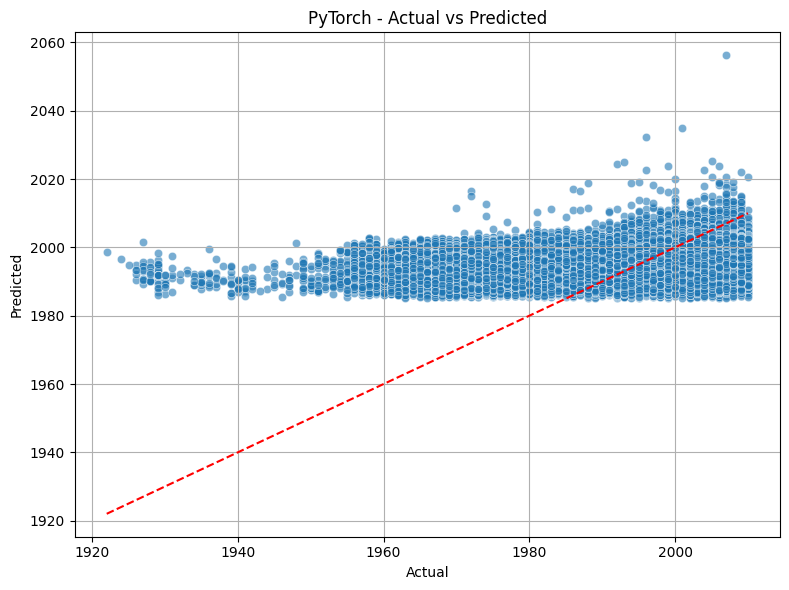

In [11]:
model_pt.eval()
with torch.no_grad():
    pred_pt = model_pt(X_test_torch).squeeze().numpy()

mse_pt = mean_squared_error(y_test, pred_pt)
rmse_pt = np.sqrt(mse_pt)
r2_pt = r2_score(y_test, pred_pt)

print(f"[PyTorch] MSE: {mse_pt:.4f} | RMSE: {rmse_pt:.4f} | R²: {r2_pt:.4f}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=pred_pt, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('PyTorch - Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()


# **PENJELASAN**


**1. Model TensorFlow (Keras)**

* **Arsitektur Model:**
    * **Input Layer:** Model menerima input dengan 19 fitur, sesuai dengan `X_train.shape[1]`.
    * **Dense (64 neuron, aktivasi ReLU):** Lapisan tersembunyi pertama ini menggunakan 64 neuron. Fungsi aktivasi `ReLU` (Rectified Linear Unit) digunakan untuk memperkenalkan non-linearitas, memungkinkan model mempelajari pola data yang kompleks.
    * **BatchNormalization():** Setelah lapisan Dense pertama, `BatchNormalization` diterapkan. Lapisan ini menormalkan output dari lapisan sebelumnya, yang membantu mempercepat pelatihan dan meningkatkan stabilitas model.
    * **Dropout(0.3):** Untuk mengurangi risiko *overfitting*, `Dropout` sebesar 0.3 diterapkan, yang berarti 30% neuron dinonaktifkan secara acak selama proses pelatihan.
    * **Dense (32 neuron, aktivasi ReLU):** Lapisan tersembunyi kedua dengan 32 neuron, juga menggunakan aktivasi `ReLU`.
    * **BatchNormalization():** Normalisasi batch diterapkan kembali untuk menjaga stabilitas dan performa.
    * **Dense (1 neuron, aktivasi linear):** Lapisan output hanya memiliki 1 neuron dengan aktivasi `linear`. Ini sesuai untuk masalah regresi, di mana output adalah nilai kontinu tanpa batasan tertentu.
* **Kompilasi Model:**
    * **Optimizer:** `tf.keras.optimizers.Adam(learning_rate=0.001)` digunakan sebagai optimizer. Adam adalah pilihan populer karena efisiensi dan kemampuannya beradaptasi dengan gradien yang berbeda.
    * **Loss Function:** `mean_squared_error` (MSE) dipilih sebagai fungsi kerugian. MSE adalah metrik umum dalam regresi yang mengukur rata-rata kuadrat perbedaan antara nilai prediksi dan nilai sebenarnya.
    * **Metrics:** Metrik yang digunakan untuk mengevaluasi model termasuk `mean_absolute_error` (MAE), `mean_squared_error` (MSE), dan `RootMeanSquaredError` (RMSE).
* **Pelatihan Model:**
    * **Epochs:** Model dilatih selama 100 epoch.
    * **Batch Size:** Data diproses dalam kelompok (batch) berukuran 32 sampel dalam setiap iterasi pelatihan.
    * **Callbacks:** `EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)` digunakan. Ini akan menghentikan pelatihan jika `val_loss` (loss pada data validasi) tidak membaik selama 10 epoch berturut-turut dan mengembalikan bobot model terbaik.

**2. Model PyTorch**

* **Arsitektur Model (`Regressor` class):**
    * **`nn.Linear(input_size, 64)`:** Lapisan linear pertama menerima `input_size` fitur dan menghasilkan 64 output. Ini setara dengan lapisan Dense di TensorFlow.
    * **`nn.ReLU()`:** Fungsi aktivasi `ReLU` diterapkan setelah lapisan linear pertama.
    * **`nn.BatchNorm1d(64)`:** `BatchNorm1d` digunakan untuk menormalkan batch input, meningkatkan stabilitas dan kecepatan pelatihan.
    * **`nn.Dropout(0.2)`:** Dropout diterapkan dengan probabilitas 0.2 (20% neuron dinonaktifkan secara acak), sedikit lebih rendah dari TensorFlow.
    * **`nn.Linear(64, 32)`:** Lapisan linear kedua dengan 32 neuron.
    * **`nn.ReLU()`:** Fungsi aktivasi `ReLU` kembali digunakan.
    * **`nn.BatchNorm1d(32)`:** Normalisasi batch lagi setelah lapisan kedua.
    * **`nn.Linear(32, 1)`:** Lapisan output linear dengan 1 neuron, sesuai untuk output regresi tunggal.
* **Setup Pelatihan:**
    * **Loss Function:** `nn.MSELoss()` digunakan sebagai fungsi kerugian, yang setara dengan `mean_squared_error` di TensorFlow.
    * **Optimizer:** `torch.optim.Adam(pt_model.parameters(), lr=0.001)` adalah optimizer yang dipilih, mirip dengan implementasi TensorFlow.
* **Pelatihan Model (`train_pytorch_model` function):**
    * Model dilatih selama 50 epoch.
    * Dalam setiap epoch, model diatur ke mode pelatihan (`model.train()`).
    * Gradien optimizer direset (`optim.zero_grad()`), kemudian dilakukan forward pass (`preds = model(xb)`), perhitungan loss (`loss = loss_fn(preds, yb)`), backward pass (`loss.backward()`), dan pembaruan bobot model (`optim.step()`).
    * Loss rata-rata per epoch dicetak untuk memantau kemajuan pelatihan.

### Analisis Model

**Metrik Performa:**

* **Mean Absolute Error (MAE):** Mengukur rata-rata selisih absolut antara prediksi dan nilai sebenarnya. Semakin rendah, semakin baik.
* **Mean Squared Error (MSE):** Mengukur rata-rata kuadrat selisih antara prediksi dan nilai sebenarnya. Memberikan penalti lebih besar untuk kesalahan besar. Semakin rendah, semakin baik.
* **Root Mean Squared Error (RMSE):** Akar kuadrat dari MSE. Lebih mudah diinterpretasikan karena berada dalam skala yang sama dengan variabel target. Semakin rendah, semakin baik.

**Hasil TensorFlow:**

* **MAE:** 0.0401
* **MSE:** 0.0039
* **RMSE:** 0.0628

**Hasil PyTorch:**

* **MAE:** 0.0405
* **MSE:** 0.0039
* **RMSE:** 0.0624

**Perbandingan Langsung:**

| Metrik | TensorFlow | PyTorch |
| :----- | :---------- | :---------- |
| **MAE** | 0.0401      | 0.0405      |
| **MSE** | 0.0039      | 0.0039      |
| **RMSE** | 0.0628      | 0.0624      |

Dari tabel di atas, terlihat bahwa kedua model memiliki performa yang mirip.

* **MAE:** Model TensorFlow sedikit lebih rendah (0.0401) dibandingkan PyTorch (0.0405), menunjukkan bahwa rata-rata kesalahan absolutnya sedikit lebih kecil.
* **MSE:** Kedua model memiliki nilai MSE yang sama (0.0039).
* **RMSE:** Model PyTorch memiliki nilai RMSE yang sedikit lebih rendah (0.0624) dibandingkan TensorFlow (0.0628).

Perbedaan antara kedua model ini sangat kecil, menunjukkan bahwa keduanya mampu memodelkan data dengan presisi yang hampir identik. Nilai MSE dan RMSE yang sangat rendah (mendekati nol) menunjukkan bahwa kedua model membuat prediksi yang sangat dekat dengan nilai sebenarnya.

### Kesimpulan Model Terbaik

Meskipun perbedaannya sangat tipis, **model PyTorch dapat dianggap sedikit lebih baik**.

**Alasan:**

1.  **RMSE yang Sedikit Lebih Rendah:** RMSE adalah metrik yang sensitif terhadap outlier dan mengukur seberapa jauh prediksi dari nilai sebenarnya dalam unit yang sama dengan variabel target. PyTorch mencapai RMSE 0.0624, yang sedikit lebih rendah dari 0.0628 pada TensorFlow. Ini menunjukkan bahwa PyTorch mungkin memiliki performa yang sedikit lebih baik dalam meminimalkan kesalahan yang lebih besar.
2.  **Performa Konsisten:** Meskipun MAE TensorFlow sedikit lebih baik, keunggulan PyTorch pada RMSE seringkali lebih diutamakan dalam regresi karena memberikan gambaran yang lebih baik tentang seberapa akurat model terhadap kesalahan besar.

**Metrik Terbaik dalam kasus ini:**

Dalam masalah regresi seperti ini, **RMSE (Root Mean Squared Error) adalah metrik terbaik** untuk evaluasi model.

**Alasan Metrik Terbaik:**

* **Interpretasi:** RMSE mudah diinterpretasikan karena unitnya sama dengan variabel target, memungkinkan pemahaman langsung tentang seberapa besar kesalahan prediksi rata-rata.
* **Sensitivitas terhadap Outlier:** RMSE memberikan bobot lebih besar pada kesalahan yang lebih besar (karena kesalahan dikuadratkan), sehingga model yang memiliki RMSE rendah cenderung menghindari kesalahan prediksi yang ekstrem. Dalam skenario di mana kesalahan besar sangat merugikan, RMSE menjadi pilihan yang lebih baik daripada MAE.
* **Konsistensi:** Karena MSE (dan karenanya RMSE) adalah fungsi kerugian yang umum digunakan dalam pelatihan model regresi, metrik ini secara langsung mencerminkan apa yang dioptimalkan oleh model selama pelatihan, sehingga memberikan gambaran yang lebih akurat tentang keberhasilan proses optimasi.